# M7_AI3_Frameworks
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad 3 propuesta en el Modulo **Técnicas Avanzadas de Machine Learning**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos.
#### Enero 7, 2025

## Enunciado
### Contexto
En 2016 se publicó el artículo Image Style Transfer Using Convolutional Neural Networks.
Este artículo describe el mecanismo de Style Transfer o “transferencia de estilo” mediante el cual se crea una nueva imagen combinando: 

- Las características de alto nivel (o contenido) de una imagen, normalmente una foto. Se encuentran en las últimas capas de una Red Neuronal Convolucional o CNN. 
- Las características de bajo nivel (o estilo) de otra imagen, normalmente un cuadro. Se encuentran en las primeras capas de una CNN. 

En esta práctica vamos a aplicar este modelo a pares de imágenes, y modificaremos distintos parámetros para ver el efecto sobre la imagen final.

Te pedimos que realices las siguientes tareas en el Colab proporcionado: 

1. Carga de las imágenes: mantén las imágenes seleccionadas por defecto o elige una imagen de contenido y otra de estilo.
2. Transfer learning: 
    - Carga en pytorch el modelo VGG19 pre-entrenado y asígnale a la variable vgg_all.
    - Carga en vgg_classifier el bloque de clasificación de vgg_all y muestra su arquitectura.
      - Pregunta 1: ¿Cuántas capas lineales contiene?
      - Pregunta 2: ¿Cuántas clases distintas puede reconocer VGG19 por defecto? 
    - Carga en vgg_features el bloque de características de vgg_all. Es el que utilizaremos en el resto de la actividad.
      - Pregunta 3: Indica los identificadores de capas convolucionales a continuación de capas de max pooling.
3. Inicializar y ejecutar la Red Neuronal con los parámetros iniciales.
4. Modificar parámetros y volver a ejecutar la Red Neuronal: 
    - Content_weight (peso del error en la capa de contenido) y style_weight (peso del error en las capas de estilo): probar con [1 y 1e6], [1e2 y 1e2], [1e2 y 1e-2]. 
    - Learning rate (tasa de aprendizaje del optimizador): probar con 0.003, 0.01, 0.1. 
    - Steps (etapas de entrenamiento): probar con 500, 1000, 2000.
        - Pregunta 4: ¿Qué influencia tienen los cambios anteriores en las imágenes intermedias y en la imagen resultante? 

# Neural Style Transfer
En el pdf de la actividad se describe brevemente el método de generación de imágenes **Neural Style Transfer**. No se pretende adquirir un conocimiento profundo de este método sino utilizar la práctica para adquirir un **conocimiento intuitivo de las Redes Neuronales Convolucionales como extractores de características**.

En primer lugar, importamos PyTorch junto con otros paquetes.

In [43]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Transfer Learning: descargamos VGG19
En esta actividad vamos a utilizar el primer bloque de VGG19, que sirve para **extraer las características** de la imagen de entrada

In [44]:
# reutilizamos el modelo pre-entrenado VGG19
vgg_all = models.vgg19(pretrained=True)

# pero seleccionamos solo el primer bloque de la red que extrae features
vgg_features = vgg_all.features

# congelamos porque solo queremos optimizar la imagen target
for param in vgg_features.parameters():
    param.requires_grad_(False)

/Users/lgutierrez/Proyectos/master-compartido/TFM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lgutierrez/Proyectos/master-compartido/TFM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Veamos la arquitectura completa del modelo VGG19

In [45]:
print(vgg_all)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## VGG19 - Clasificador
Aunque en esta práctica solo vamos a utilizar el bloque extractor de características, podemos aprovechar para echarle un vistazo al bloque de **clasificación**.

Comprobamos que el segundo bloque, el clasificador, está compuesto por:
* capas lineales (Linear)
* funciones de activación ReLU
* capas de dropout para evitar overfitting

Si quisiéramos utilizar VGG19 como clasificador de un dataset de imágenes, deberíamos sustituir este bloque por otro similar con tantas salidas como clases haya en el dataset.

In [46]:
vgg_classifier = vgg_all.classifier
print(vgg_classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


## Pasamos modelo a GPU si está disponible

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_features.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## load_image
Función para cargar una imagen

In [48]:
def load_image(img_path, max_size=300, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= max_size pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    # VGG está normalizada con los valores de Imagenet: 0.406, 0.456, 0.485 en BGR, que invertimos en RGB.
    # En rango 0-255 seria 103.94, 116.78, 123.68 en BGR
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # con :3 eliminamos el último canal de la primera dimensión, que es el alfa e indica la transparencia
    # con unsqueeze(0) añadimos como primera dimensión el batch
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

## Carga de las imágenes de contenido y estilo
Además, cambiamos tamaño de la imagen de estilo a la de contenido.

In [49]:
# cargamos las imágenes de contenido y estilo
img_quinta = "https://github.com/md-lorente/Master_BD_DS/blob/main/m%C3%B3dulo_7_aprendizaje_autom%C3%A1tico_para_machine_learning/quinta.jpeg?raw=true"
img_palamos = "https://github.com/md-lorente/Master_BD_DS/blob/main/m%C3%B3dulo_7_aprendizaje_autom%C3%A1tico_para_machine_learning/playa_palamos.jpg"
img_soto = "https://github.com/md-lorente/Master_BD_DS/blob/main/m%C3%B3dulo_7_aprendizaje_autom%C3%A1tico_para_machine_learning/soto_cruz_mazo.jpg?raw=true"

content = load_image(img_soto).to(device)

img_van_gogh = "https://github.com/md-lorente/Master_BD_DS/blob/main/m%C3%B3dulo_7_aprendizaje_autom%C3%A1tico_para_machine_learning/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg?raw=true"
img_kandinsky = "https://github.com/md-lorente/Master_BD_DS/blob/main/m%C3%B3dulo_7_aprendizaje_autom%C3%A1tico_para_machine_learning/Vassily_Kandinsky,_1913_-_Composition_7.jpg?raw=true"

# cambia tamaño de la imagen de estilo: coge los dos últimos valores de shape de la imagen de contenido
from time import sleep
error = True
while error == True:
    try:
      style = load_image(img_van_gogh, shape=content.shape[-2:]).to(device)
      error = False
    except:
      print("retry")
      sleep(1)

## im_convert
Es una función de ayuda para pasar una imagen de Tensor a numpy y poderla visualizar

In [50]:
def im_convert(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0) # cambia ancho por alto
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

## Veamos las imágenes de contenido y estilo

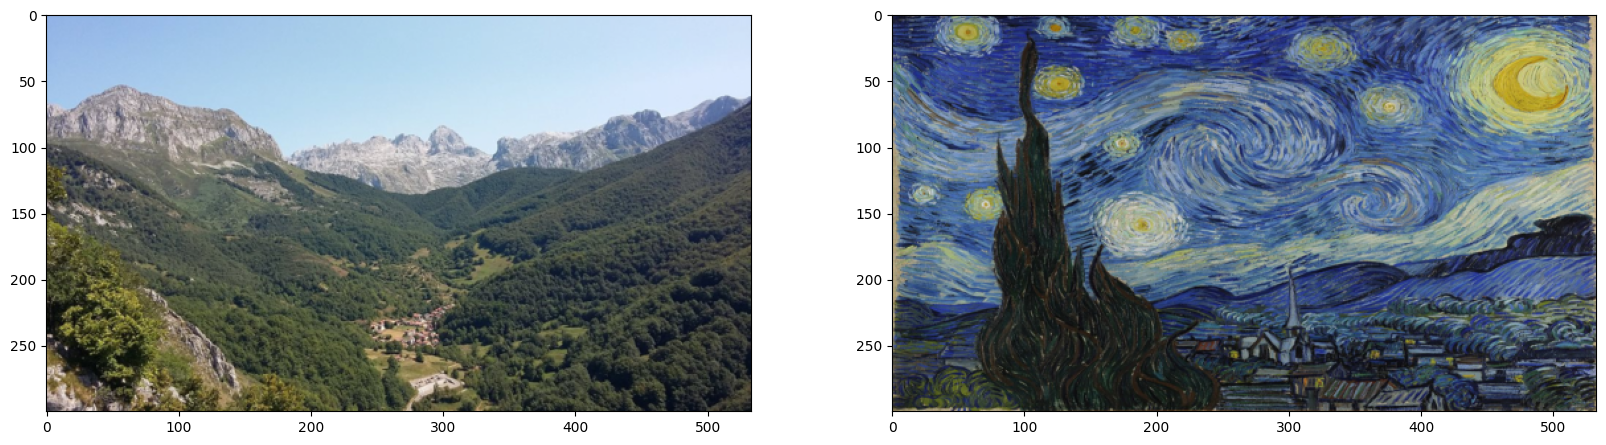

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## Capas de vgg_features
Veamos los identificadores de capas del extractor de características, vgg_features

In [52]:
print(vgg_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Extracción de características
La función get_features se utiliza para extraer las características de las imágenes de contenido y estilo.

En primer lugar, filtramos las capas que vamos a tener en cuenta para la extracción de características según se indica en el artículo de referencia. Utilizaremos varias capas para el estilo pero solo una (conv4_2) para el contenido.

A continuación, extraemos las características de la imagen para las capas seleccionadas.

In [53]:
def get_features(image, model, layers=None):

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## contenido
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules es un diccionario con todas las capas
    for name, layer in model._modules.items():
        x = layer(x) # la imagen se va transformando en cada capa...
        if name in layers: # ...pero solo extraemos las características de las capas seleccionadas
            features[layers[name]] = x

    return features


## Matriz Gram
El método Style Transfer utiliza la matriz Gram o Gramian para procesar las características.

Ver https://en.wikipedia.org/wiki/Gramian_matrix

In [54]:
def gram_matrix(tensor):

    # obtenemos batch_size, depth, height y width del Tensor
    b, d, h, w = tensor.size()

    # convertimos el tensor a 2D multiplicando dimensiones entre sí
    tensor = tensor.view(b * d, h * w)

    # calculamos la matriz gram multiplicando el tensor por su transpuesto
    gram = torch.mm(tensor, tensor.t())

    return gram

## Definimos los parámetros a probar
* Definimos los pesos de las capas de estilo. Excluimos conv4_2 porque es la capa de la que extraemos el contenido.
* Definimos valores de los pesos de contenido y estilo para la función de pérdida (content_weight, style_weight).
* Definimos la tasa de aprendizaje.
* Definimos el número de iteraciones (steps)


In [55]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

learning_rate = 0.1

steps = 500 # número de iteraciones

# definimos cada cuántas imágenes queremos hacer una visualización intermedia
show_every = 100

## Inicialización y entrenamiento del modelo
Tareas:
* definimos las capas del nuevo modelo
* inicializamos la imagen generada con la imagen de contenido
* definimos el optimizador
* modificamos la imagen generada mediante la función de pérdida, compuesta por la suma de la pérdida de estilo y la de contenido ponderadas

Pérdida total:  1060095.875


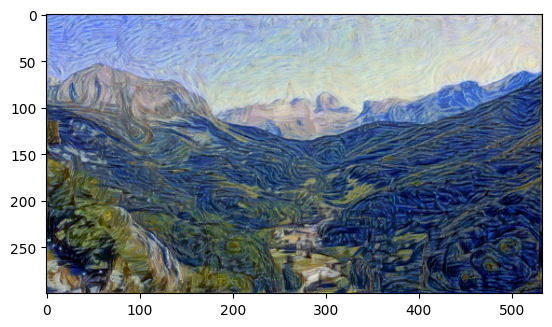

Pérdida total:  465310.15625


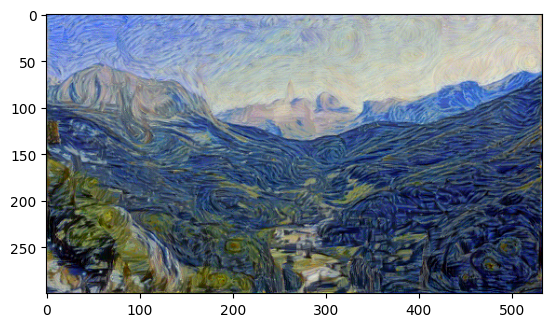

Pérdida total:  267969.59375


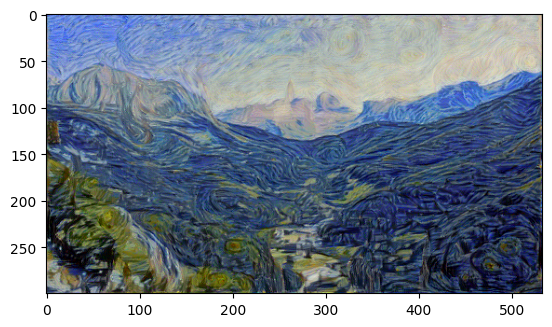

Pérdida total:  387179.75


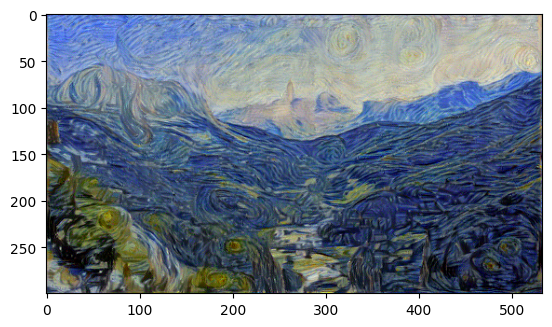

Pérdida total:  152024.859375


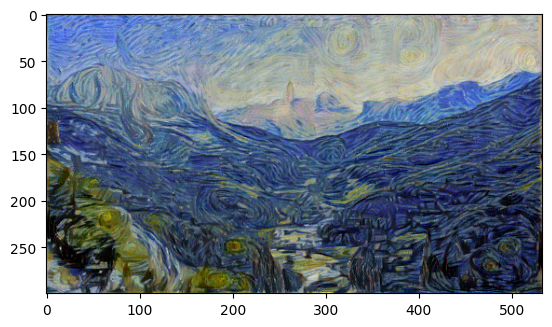

In [14]:
# extraemos características de contenido y estilo de las imágenes originales
content_features = get_features(content, vgg_features)
style_features = get_features(style, vgg_features)

# calculamos la matriz gram de cada capa de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# creamos una tercera imagen "target" que se va a ir modificando
# La inicializamos con la imagen de contenido...
# ...y le vamos cambiando el estilo
target = content.clone().requires_grad_(True).to(device)

# definimos el optimizador sobre los parámetros de la imagen target
optimizer = optim.Adam([target], lr=learning_rate)

for ii in range(1, steps+1):

    # extraemos las características de la imagen generada
    target_features = get_features(target, vgg_features)

    # definimos la función de pérdida de contenido
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # definimos la función de pérdida de estilo como suma de la pérdida de cada capa
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        # calculamos la "pérdida de estilo" de la capa actual y la ponderamos
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # la añadimos a la pérdida de estilo
        style_loss += layer_style_loss / (d * h * w)

    # calculamos la pérdida total
    total_loss = content_weight * content_loss + style_weight * style_loss

    # actualizamos la imagen generada mediante el optimizador
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # mostramos las imágenes intermedias y su pérdida
    if  ii % show_every == 0:
        print('Pérdida total: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Veamos la imagen de contenido y la generada (final)

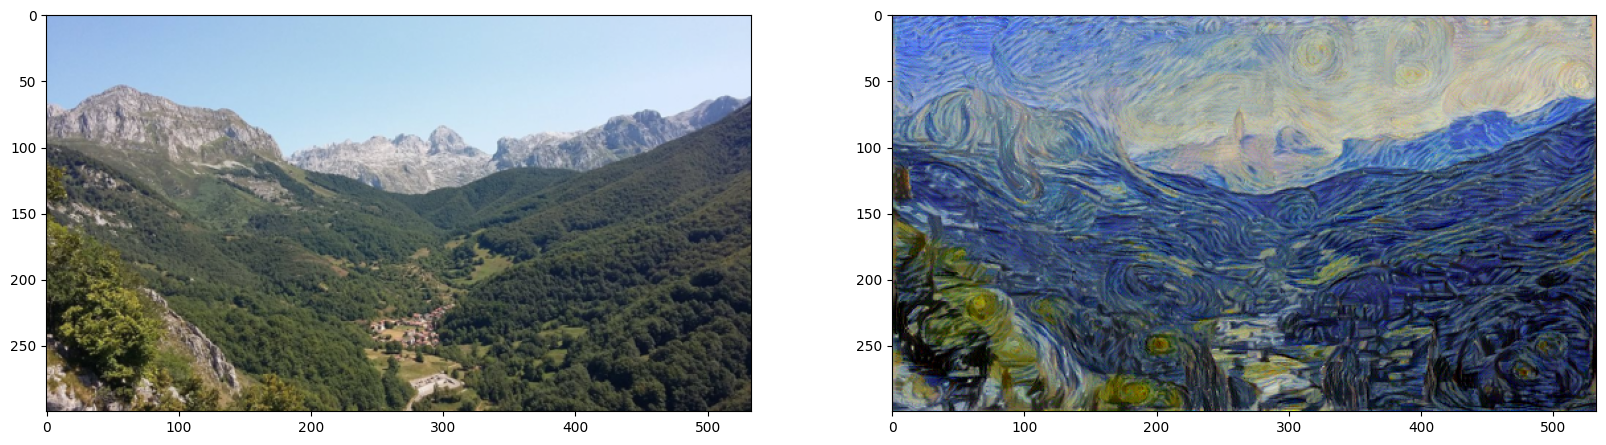

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

## Almacenamiento en local
Por último, si queremos conservar la imagen resultante, podemos bajarla imagen a nuestro ordenador.

In [ ]:
from google.colab import files
target_path = "content_style.jpg"

target_im = im_convert(target)
target_im = target_im * 255
target_im = target_im.astype('uint8')
Image.fromarray(target_im).save(target_path)

files.download(target_path)

# Preguntas
### 1 - ¿Cuántas capas lineales contiene el clasificador de VGG19
Como vimos durante el desarrollo de la actividad la red neuronal convolucional VGG19 contiene dos etapas claramente diferenciadas: la **etapa convolucional**, dedicada a la extracción de características compuesta por 5 bloques, todos ellos organizados secuencialmente, donde cada bloque está compuesto por diferentes cantidades de capas convolucionales intermedias, funciones de activación y de pooling; y una **etapa clasificadora** densamenete conectada compuesta por 3 capas lineas, con funciones de activación ReLu y capas de dropout.

Veamos como está diseñada la etapa clasificadora:

In [59]:
print(vgg_classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Podemos ver las 3 capas lineales densamente conectadas, donde las dos primeras están acompañadas de una capa rectificadora Relu y un layer de tipo Dropout, mientras que la ultima capa lineal es la que realiza la clasificación de las 1000 clases diferentes que la VGG puede discriminar.

### 2 - ¿Cuántas clases distintas puede reconocer VGG19 en su configuración original?

Al analizar la arquitectura de la red VGG19 original vemos que la última capa de su etapa clasificadora es una capa de tipo **Linear(in_features=4096, out_features=1000, bias=True)**, lo que nos dice que tiene 4096 entradas y 1000 neuronas, indicando que la red originalmente está pensanda para la distinción en 1000 clases diferentes.


### 3 - Indica los identificadores de capas convolucionales a continuación de capas de max pooling

Veamos la sección convolucional de la red VGG19

In [66]:
print(vgg_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

De la salida anterior podemos notar el diseño interno de la etapa convolucional del la red VGG19, compuesta por **5 bloques**, donde los primeros dos se componen de 2 capas convolucionales ($conv_i\_1 + conv_i\_2$) con sus funciones de activación **ReLu** y un layer **MaxPool2d** antes de pasar al siguiente bloque. Mientras que los últimos 3 bloques se componen de 4 capas convolucionales cada uno ($conv_i\_1 + conv_i\_2 + conv_i\_3 + conv_i\_4$), con sus respectivas funciones de activacion **ReLu** y una capa **MaxPool2d** previo al siguiente bloque.

Según lo anterior, podemos identificar las siguientes capas convolucionales a continuación de cada capa de max pooling y que identifican el comienzo de cada bloque dentro de la sección convolucional de la VGG19:

- (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) = cov2_1
- (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) = conv3_1
- (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) = conv4_1
- (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) = conv5_1

### 4 - ¿Qué influencia tienen los cambios solicitados (content_weight, style_weight, learning rate, steps) en las imágenes intermedias y en la imagen resultante?

Veamos el proceso de experimentación con diferentes valores en los parámetros de la red.

En esta primera etapa mantendremos constante los valores de **Learning rate** y **Steps** (valores originales) y haremos variar los pesos de los errores de stilo y contenido.

In [67]:
# content_weight = 1e2 y style_weight = 1e2
content_weight = 1e2  # alpha
style_weight = 1e2  # beta

# definimos cada cuántas imágenes queremos hacer una visualización intermedia
show_every = 100

Pérdida total:  358.1531982421875


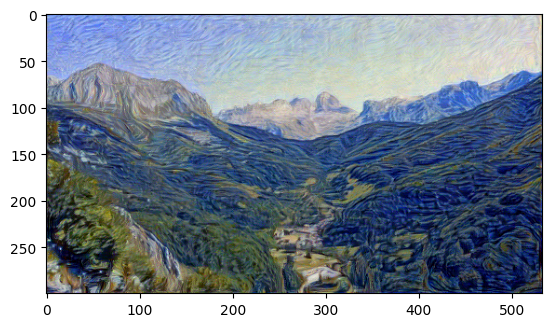

Pérdida total:  277.8480529785156


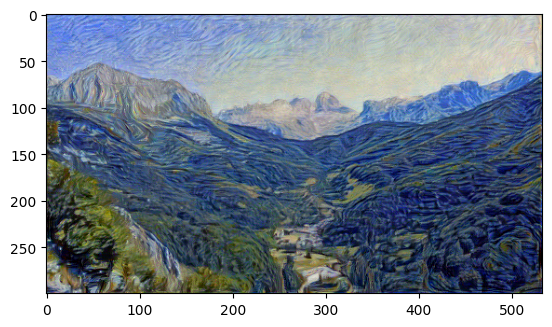

Pérdida total:  250.19427490234375


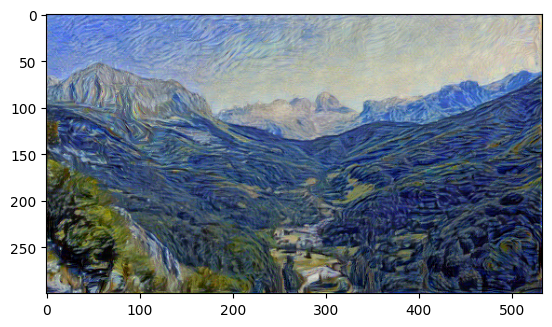

Pérdida total:  251.96975708007812


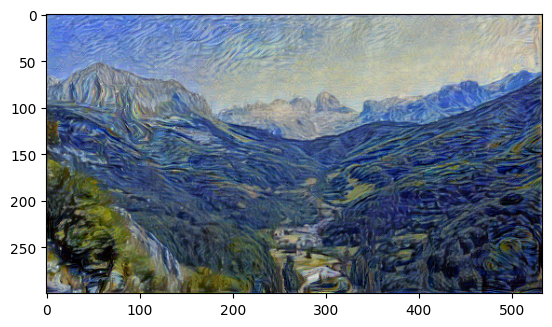

Pérdida total:  222.32186889648438


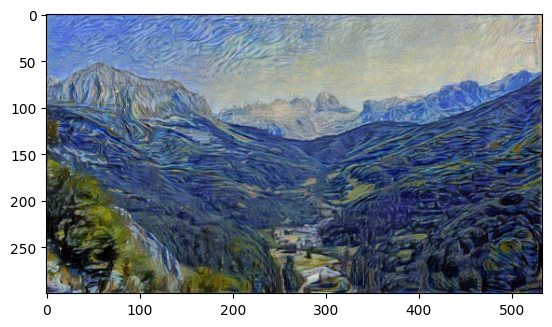

In [68]:
# extraemos características de contenido y estilo de las imágenes originales
content_features = get_features(content, vgg_features)
style_features = get_features(style, vgg_features)

# calculamos la matriz gram de cada capa de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# creamos una tercera imagen "target" que se va a ir modificando
# La inicializamos con la imagen de contenido...
# ...y le vamos cambiando el estilo
target = content.clone().requires_grad_(True).to(device)

# definimos el optimizador sobre los parámetros de la imagen target
optimizer = optim.Adam([target], lr=learning_rate)

for ii in range(1, steps+1):

    # extraemos las características de la imagen generada
    target_features = get_features(target, vgg_features)

    # definimos la función de pérdida de contenido
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # definimos la función de pérdida de estilo como suma de la pérdida de cada capa
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        # calculamos la "pérdida de estilo" de la capa actual y la ponderamos
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # la añadimos a la pérdida de estilo
        style_loss += layer_style_loss / (d * h * w)

    # calculamos la pérdida total
    total_loss = content_weight * content_loss + style_weight * style_loss

    # actualizamos la imagen generada mediante el optimizador
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # mostramos las imágenes intermedias y su pérdida
    if  ii % show_every == 0:
        print('Pérdida total: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()